# Day of the Month Seasonality

Simple investigation whether going long on several days of the month are better than others.

Key Code Assumptions:
- Data contains all working days, such that the number of the business day can be inferred purely based on the 'Date' column
- Metrics are computed on the price at the close
- The return on the data is the total return, and does not include other aspects such as dividends or coupons

### Imports and Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### PARAMETERS ###
PERIOD_AHEAD = 250

### CONSTANTS ###
SORTED_DAYNAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [4]:
DATA = (
    pd.read_csv('../data/SP500_TRI.csv')
    .loc[:,['Date', 'Close']]
)

DATA['Date'] = (
    pd.to_datetime(DATA['Date'], format='%d-%m-%Y')
)

display(DATA)

,Date,Close
0,1988-01-04,256.019989
1,1988-01-05,258.769989
2,1988-01-06,259.029999
3,1988-01-07,261.209991
4,1988-01-08,243.550003
...,...,...
9312,2024-12-17,13277.549805
9313,2024-12-18,12886.209961
9314,2024-12-19,12875.089844
9315,2024-12-20,13015.660156


### Working Day Number

For clarity: the working day number represents how many working days there were before the current working day, counting from the start of the month. Indexing starts at zero.

In [5]:
series_working_dates = DATA.copy()

series_working_dates['Year_Month'] =(
    series_working_dates['Date'].dt.to_period('M')
)

series_working_dates = (
    series_working_dates
    .groupby(['Year_Month'])
    .cumcount()
    # .groupby(0)
    # .count()
)

display(series_working_dates)

0        0
1        1
2        2
3        3
4        4
        ..
9312    11
9313    12
9314    13
9315    14
9316    15
Length: 9317, dtype: int64

### Add Day Indices

Current indices are:
- Num_Workday: the working day number
- Day_Name: the 'dd' number of the date from a yyyy-mm-dd date
- Day_Name: the name of the day, i.e. Monday, Tuesday, ...

In [6]:
data_working_day = (
    DATA
    .copy()
)

data_working_day['Num_Workday'] = series_working_dates

data_working_day['Day_Name'] = data_working_day['Date'].dt.day_name()

data_working_day['Day_Number'] = data_working_day['Date'].dt.day

display(data_working_day)

,Date,Close,Num_Workday,Day_Name,Day_Number
0,1988-01-04,256.019989,0,Monday,4
1,1988-01-05,258.769989,1,Tuesday,5
2,1988-01-06,259.029999,2,Wednesday,6
3,1988-01-07,261.209991,3,Thursday,7
4,1988-01-08,243.550003,4,Friday,8
...,...,...,...,...,...
9312,2024-12-17,13277.549805,11,Tuesday,17
9313,2024-12-18,12886.209961,12,Wednesday,18
9314,2024-12-19,12875.089844,13,Thursday,19
9315,2024-12-20,13015.660156,14,Friday,20


### Compute Returns

Columns produced:
- Single_Period_Ahead_Return: return over one row ahead
- Test_Period_Ahead_Return: total return over the test period
- Test_Period_Ahead_Avg: average daily return over the test period

In [7]:
data_returns = (
    data_working_day.copy()
)

data_returns['Test_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-PERIOD_AHEAD)
)

data_returns['Single_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-1)
)


data_returns['Test_Period_Ahead_Return'] = (
    100 * (data_returns['Test_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Single_Period_Ahead_Return'] = (
    100 * (data_returns['Single_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Test_Period_Ahead_Avg'] = (
    data_returns['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.mean)
)

data_returns = (
    data_returns
    .dropna()
)

display(data_returns)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg
249,1988-12-27,287.100006,17,Tuesday,27,28.798325,0.094040,0.107585
250,1988-12-28,287.369995,18,Wednesday,28,29.731706,0.849080,0.103567
251,1988-12-29,289.809998,19,Thursday,29,28.439327,-0.583142,0.108210
252,1988-12-30,288.119995,20,Friday,30,29.938918,-0.857282,0.113776
253,1989-01-03,285.649994,0,Tuesday,3,31.762651,1.519341,0.110918
...,...,...,...,...,...,...,...,...
9061,2023-12-18,10259.849609,11,Monday,18,29.912043,0.594655,0.103783
9062,2023-12-19,10320.860352,12,Tuesday,19,28.647703,-1.456764,0.097821
9063,2023-12-20,10170.509766,13,Wednesday,20,26.701712,1.030332,0.093354
9064,2023-12-21,10275.299805,14,Thursday,21,25.301355,0.166130,0.097057


### Compute Volatility

Columns Produced:
- Test_Period_Ahead_Std: standard deviation computed by numpy.var, over the observations of single-period returns over the test period

In [8]:
data_volatility = (
    data_returns.copy()
)

data_volatility['Test_Period_Ahead_Std'] = (
    data_volatility['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.var)
)

data_volatility['Test_Period_Ahead_Std'] = (
    np.sqrt(data_volatility['Test_Period_Ahead_Std'])
)

data_volatility = (
    data_volatility
    .dropna()
)

# data_volatility.to_csv('../data/processed.csv', index=False)

display(data_volatility)


,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std
498,1989-12-20,367.690002,13,Wednesday,20,-1.411516,0.568413,0.002163,1.017362
499,1989-12-21,369.779999,14,Thursday,21,-0.751798,0.819406,-0.000907,1.016048
500,1989-12-22,372.809998,15,Friday,22,-1.507469,-0.155572,-0.000383,1.016002
501,1989-12-26,372.230011,16,Tuesday,26,-1.378181,0.577598,-0.000721,1.015823
502,1989-12-27,374.380005,17,Wednesday,27,-1.461083,0.534217,-0.004788,1.015709
...,...,...,...,...,...,...,...,...,...
8811,2022-12-19,8127.569824,12,Monday,19,26.235146,0.107412,0.098683,0.837639
8812,2022-12-20,8136.299805,13,Tuesday,20,26.849558,1.501049,0.086851,0.838636
8813,2022-12-21,8258.429688,14,Wednesday,21,23.153071,-1.445309,0.096754,0.835094
8814,2022-12-22,8139.069824,15,Thursday,22,26.246611,0.589628,0.095060,0.834522


### Compute Sharpe

Columns Produced:
- Test_Period_Ahead_Sharpe: sharpe ratio over the test period

In [9]:
data_sharpe = (
    data_volatility.copy()
)

data_sharpe['Test_Period_Ahead_Sharpe'] = (
    data_sharpe['Test_Period_Ahead_Avg'] / data_sharpe['Test_Period_Ahead_Std']
)

display(data_sharpe)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std,Test_Period_Ahead_Sharpe
498,1989-12-20,367.690002,13,Wednesday,20,-1.411516,0.568413,0.002163,1.017362,0.002126
499,1989-12-21,369.779999,14,Thursday,21,-0.751798,0.819406,-0.000907,1.016048,-0.000893
500,1989-12-22,372.809998,15,Friday,22,-1.507469,-0.155572,-0.000383,1.016002,-0.000377
501,1989-12-26,372.230011,16,Tuesday,26,-1.378181,0.577598,-0.000721,1.015823,-0.000710
502,1989-12-27,374.380005,17,Wednesday,27,-1.461083,0.534217,-0.004788,1.015709,-0.004714
...,...,...,...,...,...,...,...,...,...,...
8811,2022-12-19,8127.569824,12,Monday,19,26.235146,0.107412,0.098683,0.837639,0.117810
8812,2022-12-20,8136.299805,13,Tuesday,20,26.849558,1.501049,0.086851,0.838636,0.103563
8813,2022-12-21,8258.429688,14,Wednesday,21,23.153071,-1.445309,0.096754,0.835094,0.115860
8814,2022-12-22,8139.069824,15,Thursday,22,26.246611,0.589628,0.095060,0.834522,0.113909


### Results

Contains computed metrics, averaged over:
1. The 'dd' date of 'dd-mm-yyyy' date
2. The workday number of the month
3. The day name

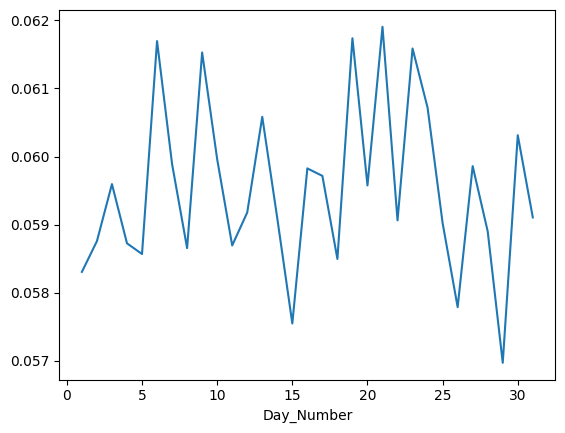

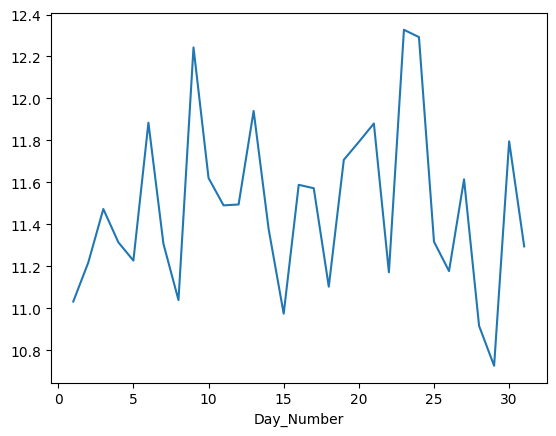

,Test_Period_Ahead_Sharpe,Test_Period_Ahead_Return
Day_Number,,
21,0.061906,11.880700
19,0.061737,11.707605
6,0.061696,11.884385
23,0.061587,12.327200
9,0.061529,12.243063
24,0.060717,12.292262
13,0.060584,11.940240
30,0.060314,11.795771
10,0.059962,11.620713


In [10]:
data_per_daynumber = data_sharpe.copy()

data_per_daynumber = (
    data_per_daynumber
    .loc[:,['Day_Number', 'Test_Period_Ahead_Sharpe', 'Test_Period_Ahead_Return']]
    .groupby('Day_Number')
    .mean()
    .sort_values(by='Test_Period_Ahead_Sharpe', ascending=False)
)

data_per_daynumber['Test_Period_Ahead_Sharpe'].sort_index().plot()
plt.show()
data_per_daynumber['Test_Period_Ahead_Return'].sort_index().plot()
plt.show()

display(data_per_daynumber)

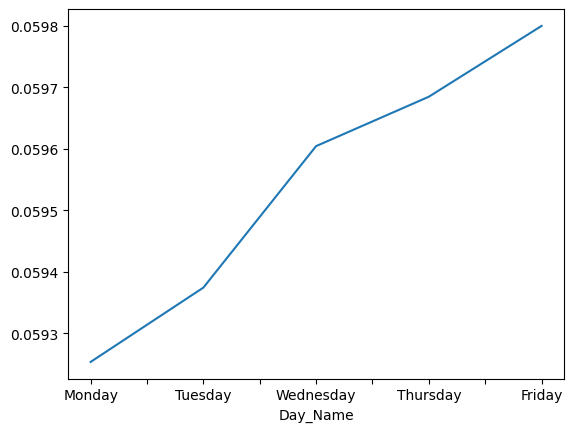

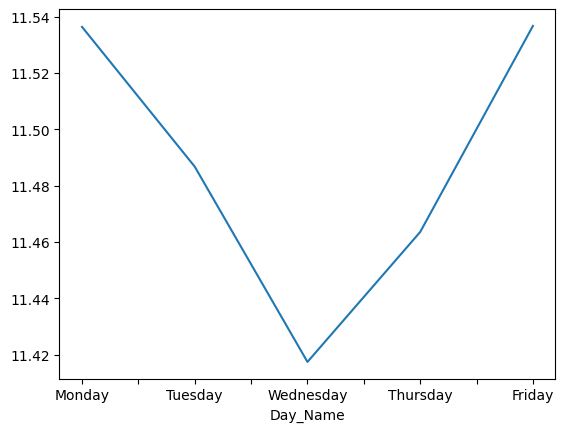

,Test_Period_Ahead_Sharpe,Test_Period_Ahead_Return
Day_Name,,
Friday,0.059799,11.536753
Thursday,0.059684,11.463596
Wednesday,0.059604,11.417452
Tuesday,0.059374,11.486790
Monday,0.059254,11.536410


In [11]:
data_per_dayname = data_sharpe.copy()

data_per_dayname = (
    data_per_dayname
    .loc[:,['Day_Name', 'Test_Period_Ahead_Sharpe', 'Test_Period_Ahead_Return']]
    .groupby('Day_Name')
    .mean()
    .sort_values(by='Test_Period_Ahead_Sharpe', ascending=False)
)

data_per_dayname['Test_Period_Ahead_Sharpe'][SORTED_DAYNAMES].plot()
plt.show()
data_per_dayname['Test_Period_Ahead_Return'][SORTED_DAYNAMES].plot()
plt.show()

display(data_per_dayname)

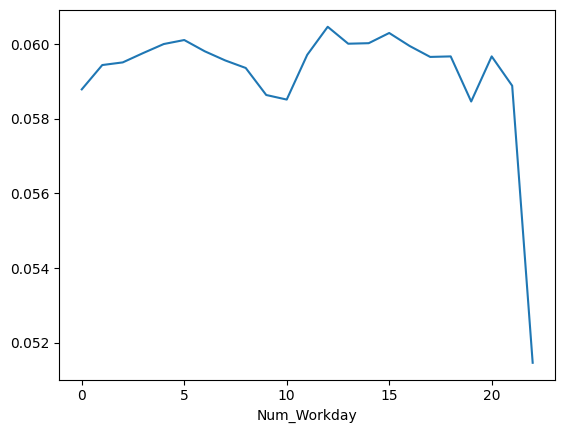

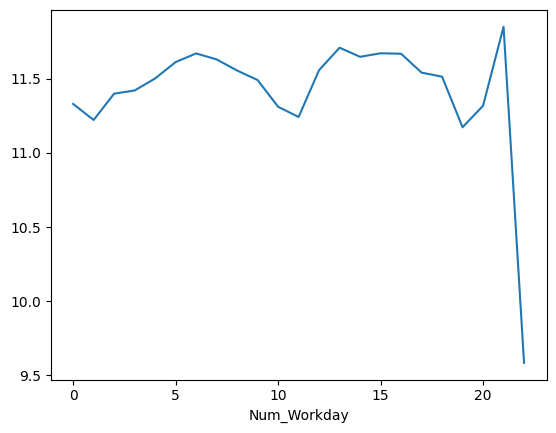

,Test_Period_Ahead_Sharpe,Test_Period_Ahead_Return
Num_Workday,,
12,0.060464,11.558725
15,0.060298,11.672412
5,0.060109,11.612926
14,0.060024,11.648447
13,0.060010,11.710108
4,0.060002,11.502610
16,0.059949,11.669346
6,0.059808,11.671330
3,0.059761,11.421382


In [12]:
data_per_workday = data_sharpe.copy()

data_per_workday = (
    data_per_workday
    .loc[:,['Num_Workday', 'Test_Period_Ahead_Sharpe', 'Test_Period_Ahead_Return']]
    .groupby('Num_Workday')
    .mean()
    .sort_values(by='Test_Period_Ahead_Sharpe', ascending=False)
)

data_per_workday['Test_Period_Ahead_Sharpe'].sort_index().plot()
plt.show()
data_per_workday['Test_Period_Ahead_Return'].sort_index().plot()
plt.show()

display(data_per_workday)

Results of S&P 500 Total Return Index:

Looking at returns by day number and day name do not seem to be helpful, as the former seems to jump around (in the charts), while the latter looks very similar for each day

From the Num_Workday results:
- Look at rows where average sharpe ratio over the test period is close to 0.6
- Observe we have the best results at around the end of the first week / beginning of the second week (Num_Workday in {3, 4, 5, 6}), and around the third week (Num_Workday in {12, 13, 14, 15, 16})
- Possible explanation: at the start of the month, returns are still affected by month-end flows, which would 'calm down' after the first few business days. 

